## Criando um Sistema de Recomendação por Imagens Digitais

Desafio de projeto

Autor: Israel de Castro Evangelista

Objetivo: Para que este sistema seja desenvolvido, vamos treinar uma rede de Deep Learning com várias classes de objetos, como por exemplo: relógio, camiseta, bicicleta, sapato, etc.

# Recomendações de Produtos Semelhantes
> Um tutorial sobre a construção de um sistema de recomendação que encontrará produtos com aparência semelhante.

- toc: true
- badges: true
- comments: true
- categories: [visão de similaridade]
- image:

In [53]:
#hide
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
# Carregar o arquivo de token baixado do Kaggle
import os
assert os.path.exists('/content/drive/MyDrive/kaggle/kaggle.json'), "Baixe o arquivo de token do Kaggle e salve em '/content/drive/MyDrive/kaggle/kaggle.json'"
!cp "/content/drive/MyDrive/kaggle/kaggle.json" ~/.kaggle/

In [55]:
#hide
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir "/content/drive/MyDrive/kaggle"
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached kaggle-1.5.13-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.13
    Uninstalling kaggle-1.5.13:
      Successfully uninstalled kaggle-1.5.13
mkdir: cannot create directory ‘/content/drive/MyDrive/kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory


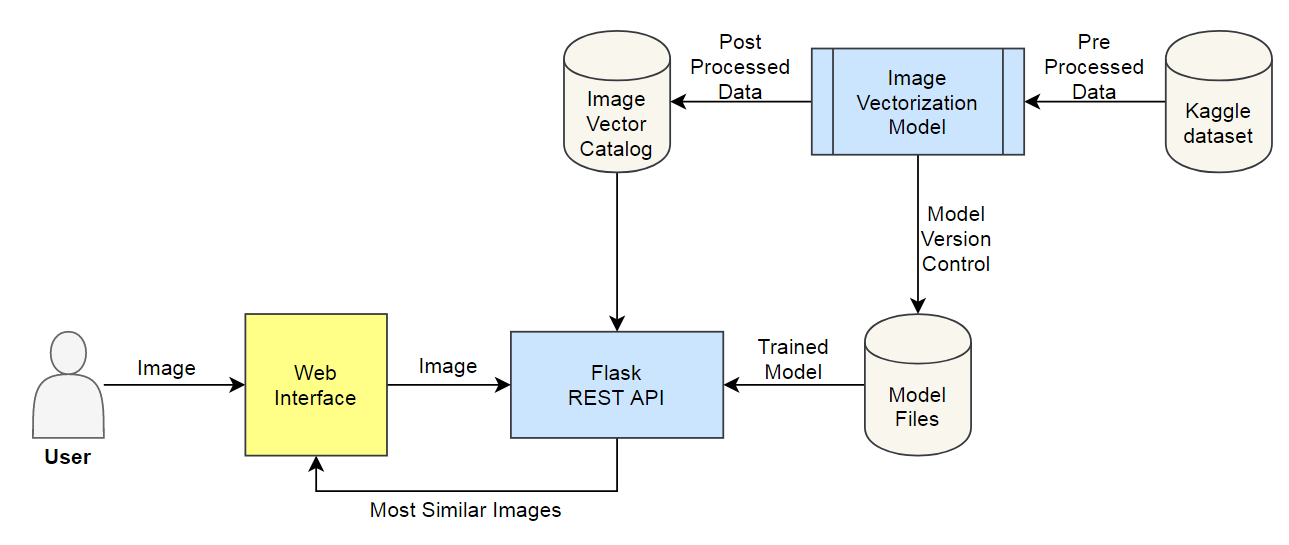

### Escolha de variáveis

- Codificador de Imagem: Qualquer modelo de classificação de imagem pré-treinado pode ser selecionado. Esses modelos são comumente conhecidos como codificadores porque seu trabalho é codificar uma imagem em um vetor de características. No nosso caso, analisamos quatro codificadores nomeados 1) MobileNet, 2) EfficientNet, 3) ResNet e 4) BiT. Após alguma pesquisa básica, decidimos selecionar o modelo BiT por causa de seu desempenho. Selecionamos a variante BiT-M-50x3 do modelo que tem tamanho de 748 MB. Mais detalhes sobre esta arquitetura podem ser encontrados na página oficial aqui.

- Sistema de Similaridade de Vetores: As imagens são representadas em um formato de vetor de características de comprimento fixo. Para o vetor de entrada fornecido, precisamos encontrar os TopK vetores mais semelhantes, mantendo em mente a eficiência de memória e o objetivo de recuperação em tempo real. Exploramos as técnicas mais populares e listamos cinco delas: Annoy, distância do cosseno, distância L1, Locally Sensitive Hashing (LSH) e Image Deep Ranking. Selecionamos o Annoy por causa de sua natureza rápida e eficiente. Mais detalhes sobre o Annoy podem ser encontrados na página oficial aqui.

- Conjunto de Dados: Este sistema é capaz de lidar com todos os tipos de conjuntos de dados de imagem. Somente o pré-processamento básico (no passo 1) precisaria de algumas modificações dependendo do conjunto de dados. Escolhemos Fashion Product Images (Small). Outros exemplos podem ser Conjunto de Dados de Imagens de Comida-11 e Conjunto de Dados de Imagens Caltech 256.

### Step 1: Data Acquisition

Download the raw image dataset into a directory. Categorize these images into their respective category directories. Make sure that images are of the same type, JPEG recommended. We will also process the metadata and store it in a serialized file, CSV recommended. 

In [56]:
#hide-output
# downloading raw images from kaggle
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: myntradataset/images/5813.jpg  
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradatas

In [69]:
files = os.listdir('/content/Fashion_data')
print(files)

['styles.csv', 'categories', 'fashion-product-images-small.zip', 'myntradataset', 'images']


In [70]:
import pandas as pd
from shutil import move
import os
from tqdm import tqdm

import os

if not os.path.exists('/content/Fashion_data'):
    os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/Fashion_data/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/Fashion_data/images/')
co = 0
if not os.path.exists('/content/Fashion_data/categories'):
   os.mkdir('/content/Fashion_data/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/Fashion_data/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

100%|██████████| 44441/44441 [02:32<00:00, 292.05it/s]

Moved 44441 images.


### Passo 2: Fine-tuning do Encoder [opcional]

Baixe o modelo de imagem pré-treinado e adicione duas camadas adicionais sobre ele: a primeira camada é uma camada de vetor de recursos e a segunda camada é a camada de classificação. Apenas treinaremos essas 2 camadas em nossos dados e, após o treinamento, selecionaremos a camada de vetor de recursos como a saída do nosso codificador refinado. Após o refinamento do modelo, salvaremos o extrator de recursos para uso posterior.

In [71]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.12.0
Hub version: 0.13.0
GPU is available


In [72]:
MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
IMAGE_SIZE = (224, 224)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 32 
N_FEATURES = 256

Using https://tfhub.dev/google/bit/m-r50x3/1 with input size (224, 224)


In [73]:
#hide
data_dir = '/content/Fashion_data/categories'

In [74]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 8886 images belonging to 7 classes.
Found 35555 images belonging to 7 classes.


In [75]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(N_FEATURES,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/bit/m-r50x3/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 6144)              211174080 
                                                                 
 dropout (Dropout)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 256)               1573120   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 212,748,999
Trainable params: 1,574,919
Non-trainable params: 211,174,080
_________________________________________

In [76]:
# Definir o otimizador e a função de perda
lr = 0.003 * BATCH_SIZE / 512 
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

# Reduza a taxa de aprendizagem por um fator de 10 nos SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [77]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
1111/1111 [==============================] - 1272s 1s/step - loss: 0.2572 - accuracy: 0.9697 - val_loss: 0.1513 - val_accuracy: 0.9862
Epoch 2/5
1111/1111 [==============================] - 1224s 1s/step - loss: 0.2041 - accuracy: 0.9793 - val_loss: 0.1513 - val_accuracy: 0.9862
Epoch 3/5
1111/1111 [==============================] - 1224s 1s/step - loss: 0.2059 - accuracy: 0.9782 - val_loss: 0.1512 - val_accuracy: 0.9861
Epoch 4/5
1111/1111 [==============================] - 1223s 1s/step - loss: 0.2030 - accuracy: 0.9787 - val_loss: 0.1512 - val_accuracy: 0.9861
Epoch 5/5
1111/1111 [==============================] - 1223s 1s/step - loss: 0.2039 - accuracy: 0.9778 - val_loss: 0.1512 - val_accuracy: 0.9861


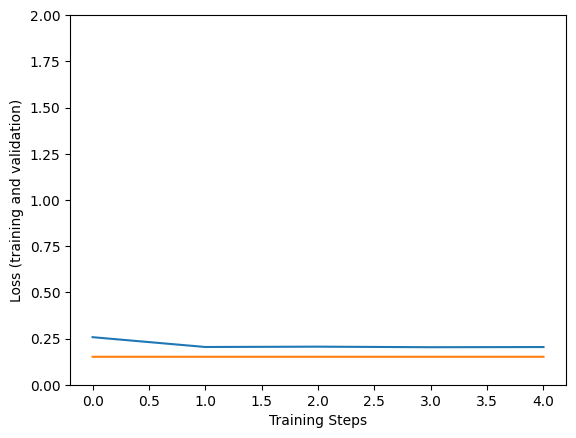

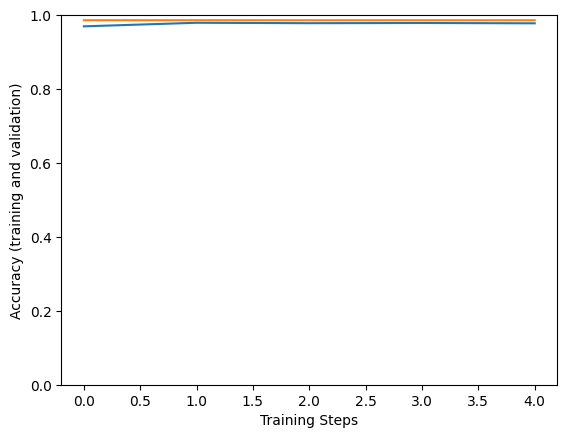

In [78]:
#hide
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [79]:
if not os.path.exists('/content/drive/MyDrive/ImgSim/'):
    os.mkdir('/content/drive/MyDrive/ImgSim/')

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
feature_extractor.save('/content/drive/MyDrive/ImgSim/bit_feature_extractor', save_format='tf')

saved_model_path = '/content/drive/MyDrive/ImgSim/bit_model'
tf.saved_model.save(model, saved_model_path)

### Passo 3: Vetorização de Imagens
Agora, usaremos o encoder (preparado no passo 2) para codificar as imagens (preparadas no passo 1). Salvaremos o vetor de características de cada imagem como uma matriz em um diretório. Após o processamento, salvaremos essas incorporações para uso posterior.

In [80]:
#hide
import tensorflow as tf
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()

In [81]:
img_paths = []
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [82]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [83]:
#hide-output
TRANSFER_LEARNING_FLAG = 1
if TRANSFER_LEARNING_FLAG:
  module = tf.keras.models.load_model('/content/drive/MyDrive/ImgSim/bit_feature_extractor')
else:
  module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1" 
  module = hub.load(module_handle)

In [84]:
imgvec_path = '/content/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

In [85]:
for filename in tqdm(img_paths[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

100%|██████████| 5000/5000 [09:21<00:00,  8.90it/s]


### Passo 4: Metadados e Indexação

Vamos atribuir um id único a cada imagem e criar dicionários para localizar informações dessa imagem: 1) dicionário do id da imagem para o nome da imagem, 2) dicionário do id da imagem para o vetor de características da imagem e 3) (opcional) dicionário do id da imagem para o id do produto metadados. Também criaremos um índice do id da imagem para o vetor de características da imagem. Em seguida, salvaremos esses dicionários e o objeto de índice para uso posterior.

In [86]:
#hide
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm
tqdm.pandas()
!pip install -q annoy
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.4/647.4 kB 37.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


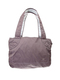

In [87]:
test_img = '/content/Fashion_data/categories/Accessories/1941.jpg'
dispImage(test_img)

In [90]:
#hide-output
styles = pd.read_csv('/content/Fashion_data/styles.csv', error_bad_lines=False)
styles['id'] = styles['id'].astype('str')
import os
root_path = os.getcwd()
styles.to_csv(root_path+'/styles.csv', index=False)

<ipython-input-90-5723c25d2744>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  styles = pd.read_csv('/content/Fashion_data/styles.csv', error_bad_lines=False)
Skipping line 6044: expected 10 fields, saw 11
Skipping line 6569: expected 10 fields, saw 11
Skipping line 7399: expected 10 fields, saw 11
Skipping line 7939: expected 10 fields, saw 11
Skipping line 9026: expected 10 fields, saw 11
Skipping line 10264: expected 10 fields, saw 11
Skipping line 10427: expected 10 fields, saw 11
Skipping line 10905: expected 10 fields, saw 11
Skipping line 11373: expected 10 fields, saw 11
Skipping line 11945: expected 10 fields, saw 11
Skipping line 14112: expected 10 fields, saw 11
Skipping line 14532: expected 10 fields, saw 11
Skipping line 15076: expected 10 fields, saw 12
Skipping line 29906: expected 10 fields, saw 11
Skipping line 31625: expected 10 fields, saw 11
Skipping line 33020: expected

In [91]:
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

In [92]:
# Defining data structures as empty dict
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configuring annoy parameters
dims = 256
n_nearest_neighbors = 20
trees = 10000

# Reads all file names which stores feature vectors 
allfiles = glob.glob('/content/img_vectors/*.npz')

t = AnnoyIndex(dims, metric='angular')

In [93]:
for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass 
  t.add_item(findex, file_vector)

5000it [00:21, 228.93it/s]


In [94]:
#hide-output
t.build(trees)
t.save('t.ann')

True

In [95]:
#hide
file_path = '/content/drive/MyDrive/ImgSim/'

In [96]:
t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

## Passo 5: Teste Local


Nós vamos carregar uma imagem aleatória e encontrar as K imagens mais similares.

In [120]:
#hide
from PIL import Image
import matplotlib.image as mpimg

In [124]:
img_addrs = ['/content/Blusa Lilica_Amazon.jpg',
             '/content/Blusa Masculina_Amazon.jpg',
             '/content/Bolsa_Amazon.jpg',
             '/content/Calça_Amazon.jpg']

In [ ]:
for img_addr in img_addrs:
  !wget -q -O img.jpg $img_addr
  test_img = 'img.jpg'
  topK = 4

  test_vec = np.squeeze(module(load_img(test_img)))

  basewidth = 224
  img = Image.open(test_img)
  wpercent = (basewidth/float(img.size[0]))
  hsize = int((float(img.size[1])*float(wpercent)))
  img = img.resize((basewidth,hsize), Image.ANTIALIAS)
  img

In [ ]:
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(20, 10))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()

## Step 6: API Call

We will build two kinds of API - 1) UI based API using Streamlit, and 2) REST API using Flask. In both the cases, we will receive an image from user, encode it with our image encoder, find TopK similar vectors using Indexing object, and retrieve the image (and metadata) using dictionaries. We send these images (and metadata) back to the user.

In [ ]:
#hide
import os
import time

In [ ]:
#hide
root_path = '/content/drive/MyDrive/ImgSim'

In [ ]:
%%writefile utils.py
### ----utils.py---- ###

import os
import tensorflow as tf
from annoy import AnnoyIndex

root_path = '/content/drive/MyDrive/ImgSim'

class Encoder:
  encoder = tf.keras.models.load_model(os.path.join(root_path, 'bit_feature_extractor'))

class Indexer:
  dims = 256
  topK = 6
  indexer = AnnoyIndex(dims, 'angular')
  indexer.load(os.path.join(root_path, 'indexer.ann'))
  
encoder = Encoder()
indexer = Indexer()

### Streamlit App

In [ ]:
%%writefile app.py
### ----app.py---- ###

import streamlit as st
import pandas as pd
import numpy as np
from PIL import Image
from annoy import AnnoyIndex
import glob
import os
import tensorflow as tf
import tarfile
import pickle
from pathlib import Path
import time
from utils import encoder, indexer

root_path = '/content/drive/MyDrive/ImgSim'

start_time = time.time()
encoder = encoder.encoder
print("---Encoder--- %s seconds ---" % (time.time() - start_time))

topK = 6

start_time = time.time()
t = indexer.indexer
print("---Indexer--- %s seconds ---" % (time.time() - start_time))

# load the meta data
meta_data = pd.read_csv(os.path.join(root_path, 'styles.csv'))

# load the mappings
file_index_to_file_name = pickle.load(open(os.path.join(root_path ,'file_index_to_file_name.p'), 'rb'))
file_index_to_file_vector = pickle.load(open(os.path.join(root_path ,'file_index_to_file_vector.p'), 'rb'))
file_index_to_product_id = pickle.load(open(os.path.join(root_path ,'file_index_to_product_id.p'), 'rb'))

# load image path mapping
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

query_path = '/content/user_query.jpg'

st.title("Image Similarity App")

uploaded_file = st.file_uploader("Choose an image...", type="jpg")

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    image.save(query_path)
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    st.write("")
    st.write("Top similar images...")
    
    start_time = time.time()
    test_vec = np.squeeze(encoder(load_img(query_path)))
    print("---Encoding--- %s seconds ---" % (time.time() - start_time))

    start_time = time.time()
    nns = t.get_nns_by_vector(test_vec, n=topK)
    print("---SimilarityIndex--- %s seconds ---" % (time.time() - start_time))

    img_files = []
    img_captions = []

    start_time = time.time()
    for i in nns:
      #image files
      img_path = str(path_dict[file_index_to_file_name[i]+'.jpg'])
      img_file = Image.open(img_path)
      img_files.append(img_file)
      #image captions
      item_id = file_index_to_product_id[i]
      img_caption = '\n'.join([str(j) for j in list(meta_data.loc[item_id].values[-5:])])
      img_captions.append(img_caption)
    print("---Output--- %s seconds ---" % (time.time() - start_time))

    st.image(img_files, caption=img_captions, width=200)

In [ ]:
! pip install -q pyngrok
! pip install -q streamlit
! pip install -q colab-everything

from colab_everything import ColabStreamlit
ColabStreamlit('app.py')

### Flask API

#### server-side

In [ ]:
%%writefile flask_app.py
### ----flask_app.py---- ###

import pandas as pd
import numpy as np
from PIL import Image
from annoy import AnnoyIndex
import glob
import os
import tensorflow as tf
import tarfile
import pickle
from pathlib import Path
import time
from utils import encoder, indexer
import io
import base64

from flask import Flask, request, jsonify, send_file

_PPATH = '/content/drive/MyDrive/ImgSim/'

start_time = time.time()
encoder = encoder.encoder
print("---Encoder--- %s seconds ---" % (time.time() - start_time))

topK = 6

start_time = time.time()
t = indexer.indexer
print("---Indexer--- %s seconds ---" % (time.time() - start_time))

# load the meta data
meta_data = pd.read_csv(_PPATH+'styles.csv')

# load the mappings
file_index_to_file_name = pickle.load(open(_PPATH+'file_index_to_file_name.p', 'rb'))
file_index_to_file_vector = pickle.load(open(_PPATH+'file_index_to_file_vector.p', 'rb'))
file_index_to_product_id = pickle.load(open(_PPATH+'file_index_to_product_id.p', 'rb'))

# load image path mapping
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

query_path = '/content/user_query.jpg'

def get_encoded_img(img):
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='PNG')
    my_encoded_img = base64.encodebytes(img_byte_arr.getvalue()).decode('ascii')
    return my_encoded_img


app = Flask(__name__)

@app.route("/fashion", methods=["POST"])
def home():
    file = request.files['image']
    # Read the image via file.stream
    img = Image.open(file.stream)
    img.save(query_path)

    start_time = time.time()
    test_vec = np.squeeze(encoder(load_img(query_path)))
    print("---Encoding--- %s seconds ---" % (time.time() - start_time))

    start_time = time.time()
    nns = t.get_nns_by_vector(test_vec, n=topK)
    print("---SimilarityIndex--- %s seconds ---" % (time.time() - start_time))

    img_files = {}
    img_captions = {}

    start_time = time.time()
    for count, i in enumerate(nns):
      #image files
      img_path = str(path_dict[file_index_to_file_name[i]+'.jpg'])
      img_file = Image.open(img_path)
      img_files[count] = get_encoded_img(img_file)
      #image captions
      item_id = file_index_to_product_id[i]
      img_caption = '\n'.join([str(j) for j in list(meta_data.loc[item_id].values[-5:])])
      img_captions[count] = img_caption
    print("---Output--- %s seconds ---" % (time.time() - start_time))

    return jsonify(img_files)

app.run(debug=True)

In [ ]:
!nohup python3 -u flask_app.py &

#### client-side

In [ ]:
from PIL import Image
from io import BytesIO
import base64
import requests

!wget -O 'img.jpg' -q 'https://images-na.ssl-images-amazon.com/images/I/61utX8kBDlL._UL1100_.jpg'

url = 'http://localhost:5000/fashion'
my_img = {'image': open('img.jpg', 'rb')}
r = requests.post(url, files=my_img)

imgs = []
for i in range(6):
  img = base64.decodebytes(r.json()[str(i)].encode('ascii'))
  img = Image.open(BytesIO(img)).convert('RGBA')
  imgs.append(img)

imgs[1]

## Passo 7: Implantação no AWS Elastic BeanStalk

A API foi implantada na infraestrutura de nuvem da AWS usando o serviço AWS Elastic Beanstalk.

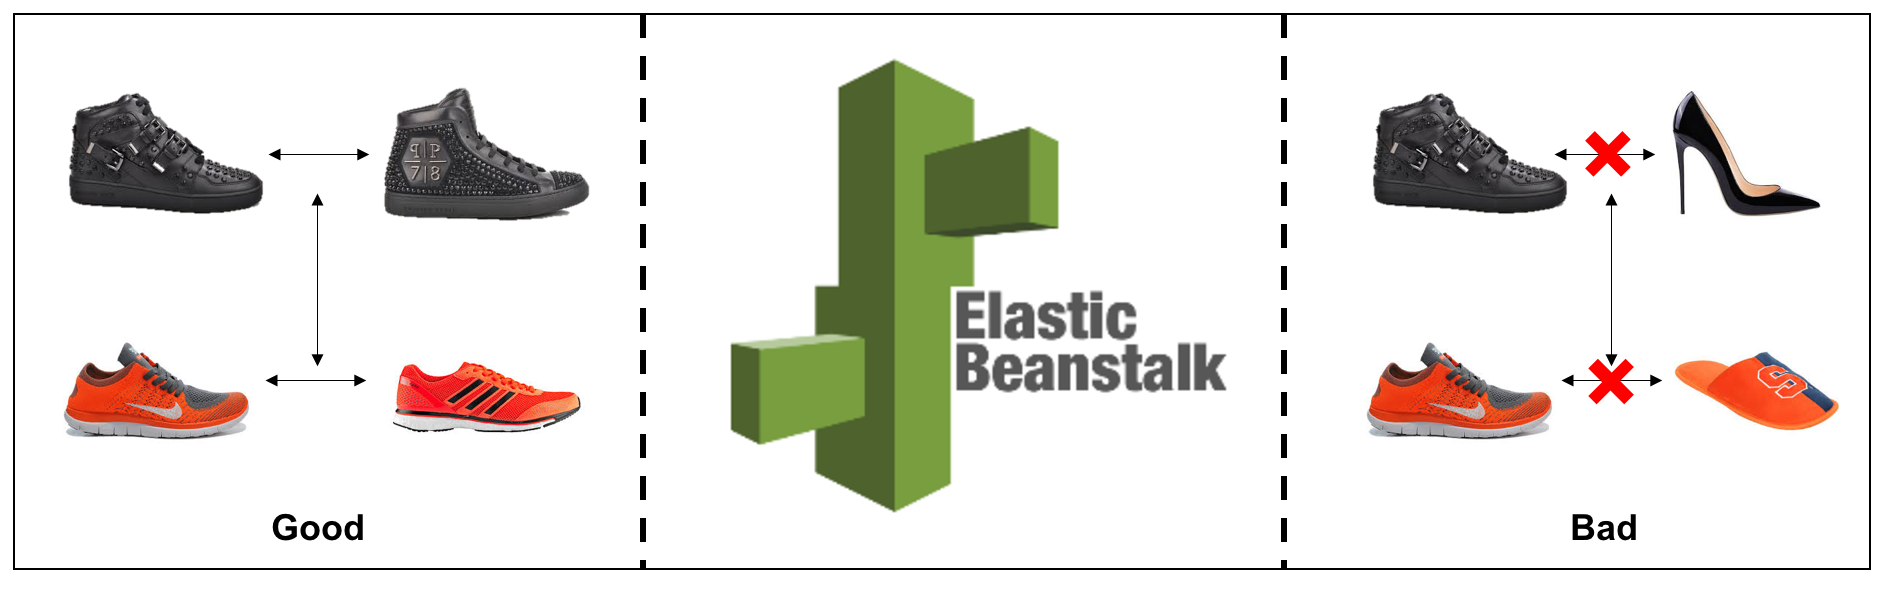

### application.py

In [ ]:
#collapse
%%writefile ./ebsapp/application.py
import os
import zipfile
import requests
from tqdm import tqdm
from shutil import move
from pandas import read_csv
from pathlib import Path
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import glob
import json
from tqdm import tqdm
from annoy import AnnoyIndex
from scipy import spatial
import pickle
import time
from PIL import Image
import tarfile
import io
import base64
from flask import Flask, request, jsonify, send_file
from flask import redirect, url_for, flash, render_template

# path = Path(__file__)
# _PPATH = str(path.parents[1])+'/'
_PPATH = os.path.join(os.getcwd(), 'mytemp')

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

module_handle = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
module = hub.load(module_handle)

def allowed_file(filename):
    return '.' in filename and \
           filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

topK = 5
threshold = 0.3
UPLOAD_FOLDER = _PPATH
ALLOWED_EXTENSIONS = set(['zip'])

application = Flask(__name__)
           
@application.route('/')
def hello_world():
    return "Hello world!"

@application.route('/original_images', methods=['POST'])
def upload_zip1():
  os.makedirs(_PPATH, exist_ok=True)
  shutil.rmtree(_PPATH)
  os.makedirs(_PPATH, exist_ok=True)
  os.chdir(_PPATH)
  file = request.files['file']
  if file and allowed_file(file.filename):
      file.save(os.path.join(UPLOAD_FOLDER, 'zip1.zip'))

  zip1_path = os.path.join(_PPATH, 'zip1.zip')
  zip1_ipath = os.path.join(_PPATH, 'zip1')
  os.makedirs(zip1_ipath, exist_ok=True)
  with zipfile.ZipFile(zip1_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(_PPATH, 'zip1'))

  img_paths = []
  for path in Path(zip1_ipath).rglob('*.jpg'):
    img_paths.append(path)

  imgvec_path = os.path.join(_PPATH, 'vecs1')
  Path(imgvec_path).mkdir(parents=True, exist_ok=True)

  for filename in tqdm(img_paths):
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    if not os.path.exists(out_path_file):
      img = load_img(str(filename))
      features = module(img)
      feature_set = np.squeeze(features)
      print(features.shape)
      np.savetxt(out_path_file, feature_set, delimiter=',')

  # Defining data structures as empty dict
  file_index_to_file_name = {}
  file_index_to_file_vector = {}

  # Configuring annoy parameters
  dims = 2048
  n_nearest_neighbors = 20
  trees = 10000

  # Reads all file names which stores feature vectors 
  allfiles = glob.glob(os.path.join(_PPATH, 'vecs1', '*.npz'))

  t = AnnoyIndex(dims, metric='angular')

  for findex, fname in tqdm(enumerate(allfiles)):
    file_vector = np.loadtxt(fname)
    file_name = os.path.basename(fname).split('.')[0]
    file_index_to_file_name[findex] = file_name
    file_index_to_file_vector[findex] = file_vector
    t.add_item(findex, file_vector)

  t.build(trees)

  file_path = os.path.join(_PPATH,'models/indices/')
  Path(file_path).mkdir(parents=True, exist_ok=True)

  t.save(file_path+'indexer.ann')
  pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
  pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))

  return 'File processed on the server status OK!'

@application.route('/test_images', methods=['POST'])
def upload_zip2():
  os.chdir(_PPATH)
  file = request.files['file']
  if file and allowed_file(file.filename):
      file.save(os.path.join(UPLOAD_FOLDER, 'zip2.zip'))

  zip2_path = os.path.join(_PPATH, 'zip2.zip')
  zip2_ipath = os.path.join(_PPATH, 'zip2')
  os.makedirs(zip2_ipath, exist_ok=True)
  with zipfile.ZipFile(zip2_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(_PPATH, 'zip2'))

  query_files = []
  for path in Path(zip2_ipath).rglob('*.jpg'):
    query_files.append(path)
  
  dims = 2048
  indexer = AnnoyIndex(dims, 'angular')
  indexer.load(os.path.join(_PPATH,'models/indices/indexer.ann'))
  file_index_to_file_name = pickle.load(open(os.path.join(_PPATH,'models/indices/file_index_to_file_name.p'), 'rb'))

  results = pd.DataFrame(columns=['qid','fname','dist'])

  for q in query_files:
    temp_vec = np.squeeze(module(load_img(str(q))))
    nns = indexer.get_nns_by_vector(temp_vec, n=topK, include_distances=True)
    col1 = [q.stem]*topK
    col2 = [file_index_to_file_name[x] for x in nns[0]]
    col3 = nns[1]
    results = results.append(pd.DataFrame({'qid':col1,'fname':col2,'dist':col3}))
    results = results[results.dist<=threshold]
  
  results = results.reset_index(drop=True).T.to_json()
  return results
  
 # run the app.
if __name__ == "__main__":
    # Setting debug to True enables debug output. This line should be
    # removed before deploying a production app.
    application.debug = True
    application.run()

### requirements.txt

In [ ]:
#collapse
%%writefile ./ebsapp/requirements.txt
annoy==1.16.3
Pillow==2.2.2
click==7.1.2
Flask==1.1.2
itsdangerous==1.1.0
Jinja2==2.11.2
MarkupSafe==1.1.1
Werkzeug==1.0.1
numpy==1.18.5
pandas==1.0.5
pathlib==1.0.1
pip-tools==4.5.1
requests==2.23.0
scipy==1.4.1
tensorflow==2.0.0b1
tensorflow-hub==0.8.0
tqdm==4.41.1
urllib3==1.24.3
zipfile36==0.1.3

### packages.config

In [ ]:
#collapse
%%writefile ./ebsapp/.ebextensions/01_packages.config
packages:
  yum:
    gcc-c++: []
    unixODBC-devel: []
files:
  "/etc/httpd/conf.d/wsgi_custom.conf":
    mode: "000644"
    owner: root
    group: root
    content: |
      WSGIApplicationGroup %{GLOBAL}

### extras
some handy EBS commands

In [ ]:
#collapse
# !pip install aws.sam.cli
# !sam init

# %cd my-app

# !git config --global user.email "<email>"
# !git config --global user.name  "sparsh-ai"
# !git init
# !git status
# !git add .
# !git commit -m 'commit'

# !pip install awscli
# !aws configure

# !sam build && sam deploy
# !pip install flask-lambda-python36

# !aws ec2 create-key-pair --key-name MyKeyPair --query 'KeyMaterial' --output text > MyKeyPair.pem
# !chmod 400 MyKeyPair.pem
# !aws ec2 describe-instances --filters "Name=instance-type,Values=t2.micro" --query "Reservations[].Instances[].InstanceId"
# !ssh -i MyKeyPair.pem ec2-user@ec2-50-xx-xx-xxx.compute-1.amazonaws.com

# !git clone https://github.com/aws/aws-elastic-beanstalk-cli-setup.git
# build-essential zlib1g-dev libssl-dev libncurses-dev libffi-dev libsqlite3-dev libreadline-dev libbz2-dev

# !pip install awscli
# !pip install awsebcli
# !aws configure

# !mkdir eb-flask
# %cd eb-flask

# python --version
# pip install awsebcli --upgrade --user
# eb --version
# mkdir eb-flask
# cd eb-flask
# pip install virtualenv
# virtualenv virt
# source virt/bin/activate
# pip install flask
# pip freeze
# pip freeze > requirements.txt
# python application.py
# eb init -p python-3.6 my-app --region us-east-1
# pip install zip-files

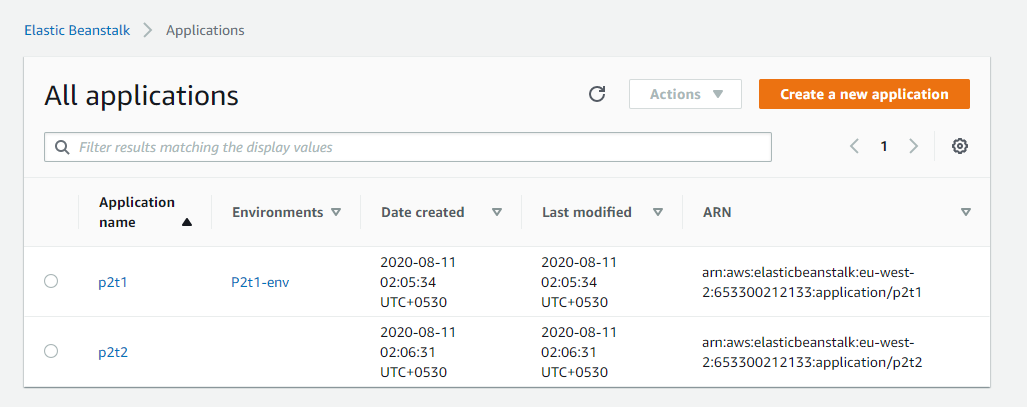